In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('DBLP-HCN')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

Empty DataFrame
Columns: [src, dst, type]
Index: []


In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

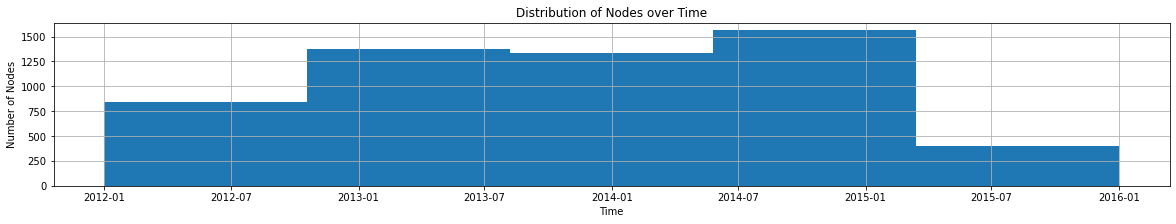

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 10687
Number of Edges: 16533
Density: 0.00014477070406267417


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 3.0940394872274726
Median Degree: 3.0


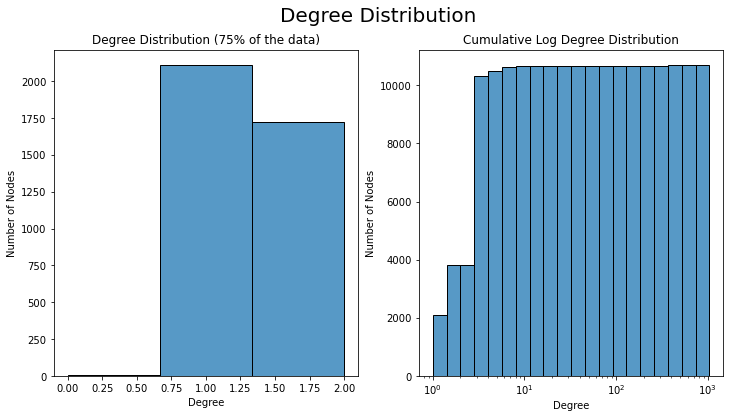

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,1041,aaai
1,898,cvpr
2,689,nips
3,474,icdm
4,462,icml
5,461,ijcai
6,299,icde
7,240,pkdd
8,210,pakdd
9,198,ecir


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 8


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,10683.000000,10683.000000,10683.000000,8576.0
mean,0.000290,0.000449,0.000094,0.0
std,0.001649,0.009262,0.000447,0.0
min,0.000094,0.000000,0.000039,0.0
25%,0.000187,0.000000,0.000065,0.0
50%,0.000281,0.000073,0.000084,0.0
75%,0.000281,0.000187,0.000093,0.0
max,0.097454,0.756028,0.025851,0.0


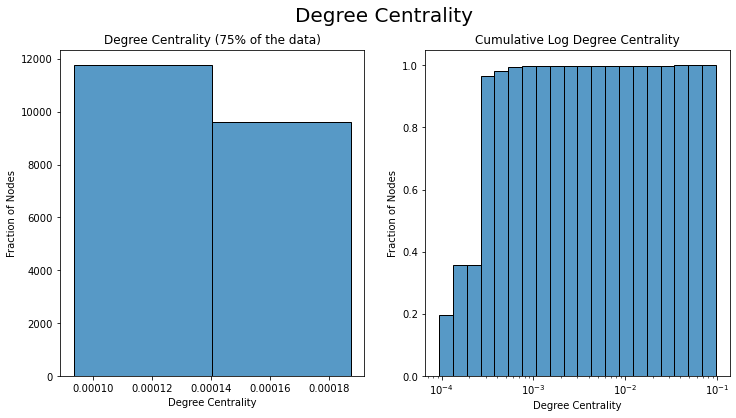

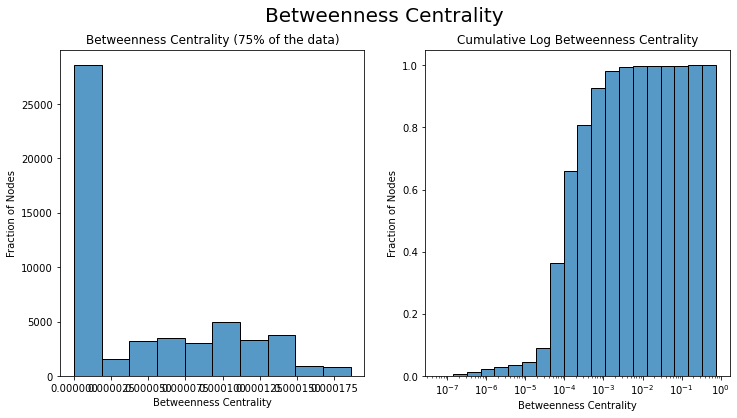

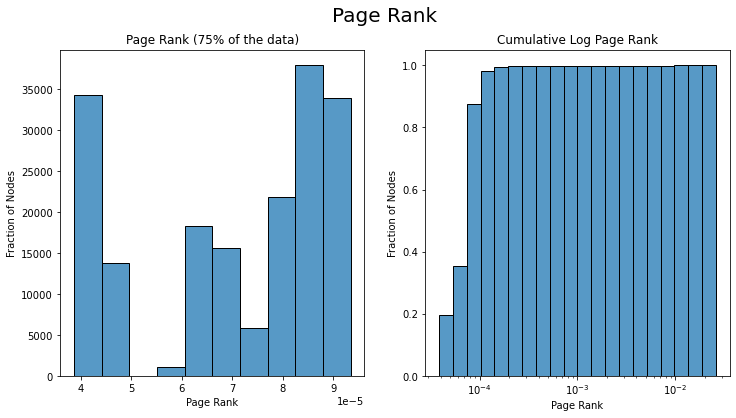

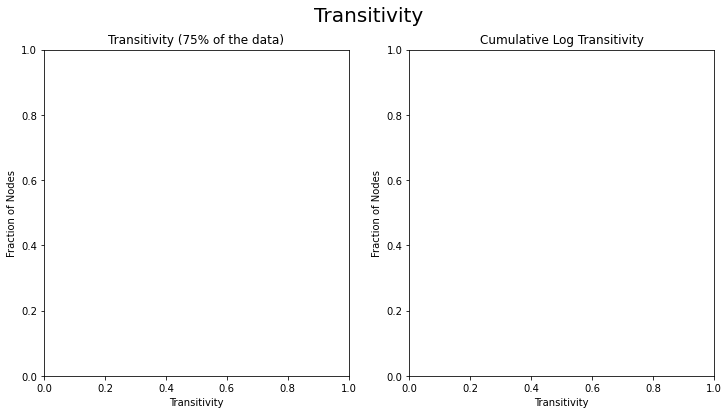

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.756028,aaai,0.025851,aaai,0.0,&Eacute
1,0.084067,cvpr,0.252134,"Ask, and Shall You Receive? Understanding Desi...",0.023406,cvpr,0.0,Tractable Queries for Lightweight Description ...
2,0.064501,nips,0.252088,Inferring Interpersonal Relations in Narrative...,0.017231,nips,0.0,R1SVM: A Randomised Nonlinear Approach to Larg...
3,0.044374,icdm,0.252088,Modeling Evolving Relationships Between Charac...,0.012292,icdm,0.0,Domain Adaptation on the Statistical Manifold.
4,0.043250,icml,0.243503,Discriminatively Enhanced Topic Models.,0.011525,ijcai,0.0,Mahsa Baktashmotlagh
5,0.043157,ijcai,0.243256,icdm,0.011262,icml,0.0,Non-Linear Stationary Subspace Analysis with A...
6,0.027991,icde,0.135746,cvpr,0.008234,icde,0.0,GUISE: Uniform Sampling of Graphlets for Large...
7,0.022468,pkdd,0.087508,nips,0.006225,pkdd,0.0,Mahmood Neshati
8,0.019659,pakdd,0.050991,icml,0.005861,ecir,0.0,Mahito Sugiyama
9,0.018536,ecir,0.047895,icde,0.005586,pakdd,0.0,Mahdi Pakdaman Naeini


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components('weak').giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 5
Size of the largest component: 10683


Text(0.5, 1.0, 'Connected Components')

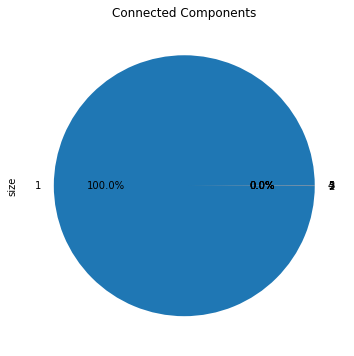

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,5162,2.135219,2.0
Paper,Paper,5511,3.000000,3.0
Venue,Venue,14,393.642857,269.5


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

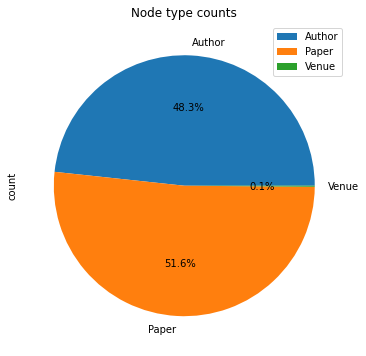

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

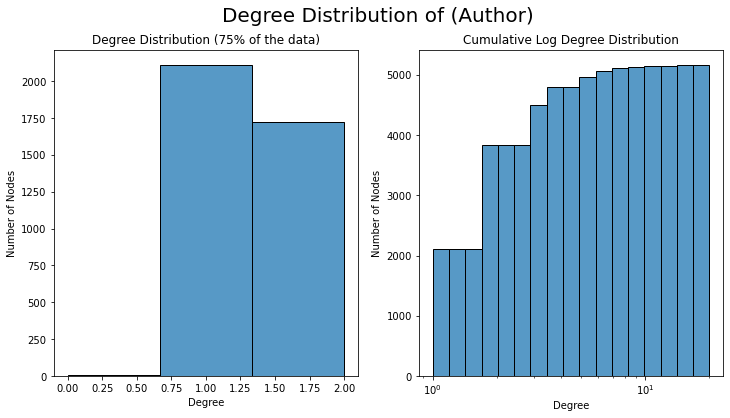

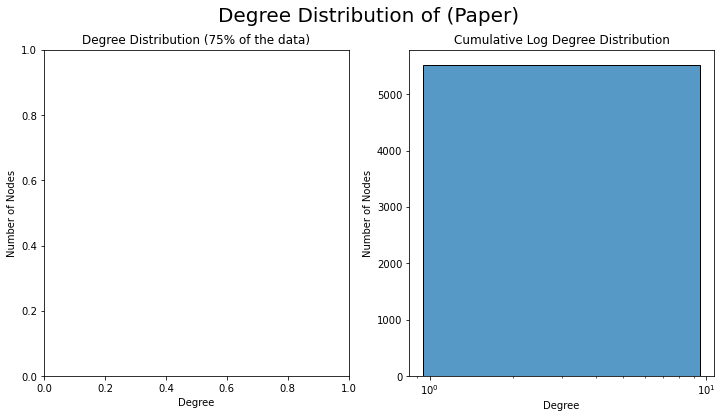

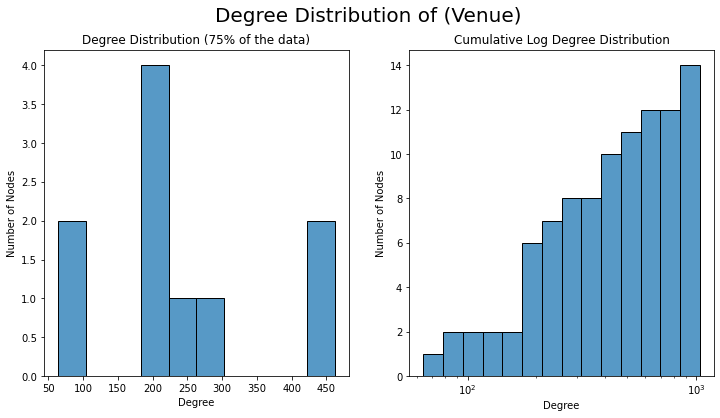

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,20,Feiping Nie
1,19,Jos&eacute
2,16,Jun Zhu
3,15,Jiliang Tang
4,13,Huan Xu
5,13,Deguang Kong
6,13,Chris H. Q. Ding
7,13,Peng Zhang
8,13,Andr&eacute
9,12,Lei Chen 0002


Top 10 Degree Nodes of Type (Paper)


,value,label
0,3,Distributed Submodular Maximization: Identifyi...
1,3,"GS-Orthogonalization Based ""Basis Feature"" Sel..."
2,3,Multi-instance Multi-graph Dual Embedding Lear...
3,3,The Independence of Fairness-Aware Classifiers.
4,3,Directional Higher Order Information for Spati...
5,3,The Eyes of the Beholder: Gender Prediction Us...
6,3,Handling Class Overlap and Imbalance to Detect...
7,3,Focused crawling for the hidden web.
8,3,SNOC: Streaming Network Node Classification.
9,3,User communities evolution in microblogs: A pu...


Top 10 Degree Nodes of Type (Venue)


,value,label
0,1041,aaai
1,898,cvpr
2,689,nips
3,474,icdm
4,462,icml
5,461,ijcai
6,299,icde
7,240,pkdd
8,210,pakdd
9,198,ecir


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 2


,type,count
AUTHORED,AUTHORED,11022
PUBLISHED_IN,PUBLISHED_IN,5511


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

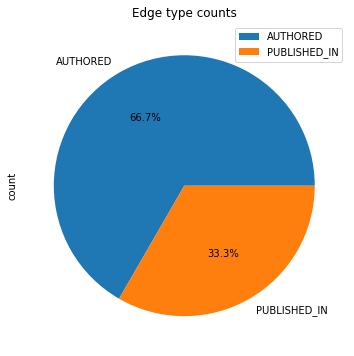

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001872,Feiping Nie,0.009385,Xin Wang,0.000453,Feiping Nie,0.0,Yuanhua Lv
1,0.001779,Jos&eacute,0.008980,Jun Zhu,0.000444,Jos&eacute,0.0,retken
2,0.001498,Jun Zhu,0.008853,Feiping Nie,0.000371,Jun Zhu,0.0,Ngo Anh Vien
3,0.001404,Jiliang Tang,0.007593,Yu Zhang,0.000341,Jiliang Tang,0.0,Xuehua Zhao
4,0.001217,Peng Zhang,0.007505,J&ouml,0.000330,Peng Zhang,0.0,Bo Yang 0008
5,0.001217,Deguang Kong,0.006711,Jos&eacute,0.000328,Andr&eacute,0.0,Jeremy C. Weiss
6,0.001217,Chris H. Q. Ding,0.006506,Andr&eacute,0.000309,Deguang Kong,0.0,Louis-Philippe Morency
7,0.001217,Huan Xu,0.006480,Peng Zhang,0.000307,Lei Chen 0002,0.0,Zhi-Hong Deng
8,0.001217,Andr&eacute,0.006152,Chris H. Q. Ding,0.000304,Huan Xu,0.0,Wei Ding 0003
9,0.001123,Lei Chen 0002,0.005984,Wei Chen,0.000300,Chris H. Q. Ding,0.0,Jing Gao


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000281,Partition-wise Linear Models.,0.252134,"Ask, and Shall You Receive? Understanding Desi...",0.00012,Temporal Multinomial Mixture for Instance-Orie...,0.0,Partition-wise Linear Models.
1,0.000281,Self-Training with Selection-by-Rejection.,0.252088,Inferring Interpersonal Relations in Narrative...,0.00012,Leveraging Latent Concepts for Retrieving Rele...,0.0,Self-Training with Selection-by-Rejection.
2,0.000281,Content-based recommendations with Poisson fac...,0.252088,Modeling Evolving Relationships Between Charac...,0.00012,VisNavi: Citation Context Visualization and Na...,0.0,Content-based recommendations with Poisson fac...
3,0.000281,Listening to the Crowd: Automated Analysis of ...,0.243503,Discriminatively Enhanced Topic Models.,0.00012,Integrating IR Technologies for Professional S...,0.0,Listening to the Crowd: Automated Analysis of ...
4,0.000281,Rule Mining Based on Nonmonotonic Rule Layers ...,0.007201,Proximal Operators for Multi-Agent Path Planning.,0.00012,Ontology-Based Word Sense Disambiguation for S...,0.0,Rule Mining Based on Nonmonotonic Rule Layers ...
5,0.000281,Sparse Perceptron Decision Tree for Millions o...,0.005294,Heterogeneous Visual Features Fusion via Spars...,0.00012,Handling Topic Drift for Topic Tracking in Mic...,0.0,Sparse Perceptron Decision Tree for Millions o...
6,0.000281,The Sample-Complexity of General Reinforcement...,0.004285,On k-Path Covers and their applications.,0.00012,Using Document-Quality Measures to Predict Web...,0.0,The Sample-Complexity of General Reinforcement...
7,0.000281,Learning as MAP Inference in Discrete Graphica...,0.004040,Multi-label ReliefF and F-statistic feature se...,0.00012,Geographical Latent Variable Models for Microb...,0.0,Learning as MAP Inference in Discrete Graphica...
8,0.000281,A Unified Framework for Probabilistic Componen...,0.004036,Dynamic Concept Composition for Zero-Example E...,0.00012,Extracting Event-Related Information from Arti...,0.0,A Unified Framework for Probabilistic Componen...
9,0.000281,Deep Symmetry Networks.,0.003966,A General Framework for Publishing Privacy Pro...,0.00012,"Collaborative Information Retrieval: Concepts,...",0.0,Deep Symmetry Networks.


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.756028,aaai,0.025851,aaai,0.0,pakdd
1,0.084067,cvpr,0.243256,icdm,0.023406,cvpr,0.0,icde
2,0.064501,nips,0.135746,cvpr,0.017231,nips,0.0,ecir
3,0.044374,icdm,0.087508,nips,0.012292,icdm,0.0,dasfaa
4,0.043250,icml,0.050991,icml,0.011525,ijcai,0.0,icdm
5,0.043157,ijcai,0.047895,icde,0.011262,icml,0.0,ijcai
6,0.027991,icde,0.034035,ecir,0.008234,icde,0.0,icml
7,0.022468,pkdd,0.026120,ijcai,0.006225,pkdd,0.0,vldb
8,0.019659,pakdd,0.024638,dasfaa,0.005861,ecir,0.0,pkdd
9,0.018536,ecir,0.022547,pkdd,0.005586,pakdd,0.0,cvpr


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7759186505569621
Number of communities: 58


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

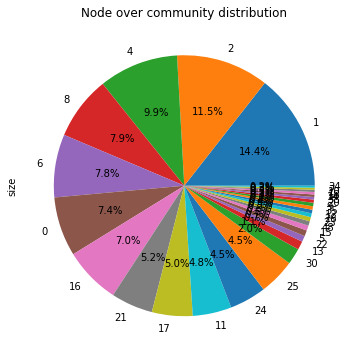

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.043157,ijcai,0.026120,ijcai,0.011525,ijcai,0.0,&Aacute
1,0.001030,Vaishak Belle,0.005373,Jo&atilde,0.000262,Fr&eacute,0.0,Blai Bonet
2,0.001030,Fr&eacute,0.002827,GSMDPs for Multi-Robot Sequential Decision-Mak...,0.000259,Vaishak Belle,0.0,Ashish Sabharwal
3,0.000843,Edith Elkind,0.002827,Partial MUS Enumeration.,0.000243,Jo&atilde,0.0,Athirai Aravazhi Irissappane
4,0.000843,Jo&atilde,0.001932,Vaishak Belle,0.000218,Edith Elkind,0.0,Barry Hurley 0001
5,0.000749,Piotr Faliszewski,0.001655,Robust Winners and Winner Determination Polici...,0.000209,Diego Calvanese,0.0,Barry O^&*Sullivan
6,0.000749,Giuseppe De Giacomo,0.001543,On Order-Constrained Transitive Distance Clust...,0.000203,Giuseppe De Giacomo,0.0,Ben Horsburgh
7,0.000749,Diego Calvanese,0.001324,Learning for Decentralized Control of Multiage...,0.000191,Piotr Faliszewski,0.0,Benjamin Kaufmann
8,0.000655,Craig Boutilier,0.001283,Zhiding Yu,0.000172,Craig Boutilier,0.0,Bin Xu
9,0.000562,d&eacute,0.001101,Semi-Supervised Dictionary Learning via Struct...,0.000159,Micha&euml,0.0,Cam-Tu Nguyen


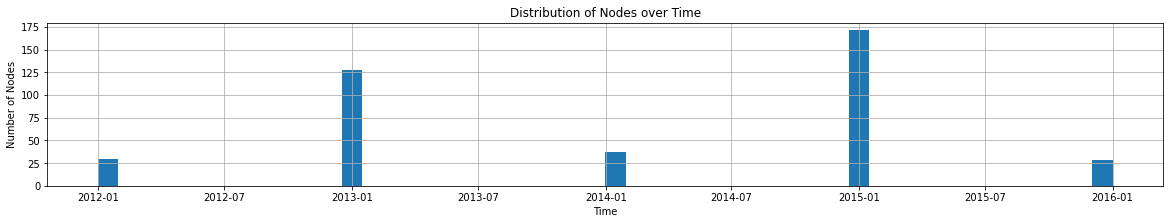

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.084067,cvpr,0.135746,cvpr,0.023406,cvpr,0.0,From random walks to distances on unweighted g...
1,0.001123,Kyoung Mu Lee,0.005746,Chao Zhang,0.000294,Kyoung Mu Lee,0.0,Christian Simon
2,0.000843,Eric P. Xing,0.003534,Eric P. Xing,0.000217,Eric P. Xing,0.0,Christian J. Schuler
3,0.000749,Xiaogang Wang,0.003408,On Machine Learning towards Predictive Sales P...,0.000205,Chao Zhang,0.0,Christian Hane
4,0.000749,Chao Zhang,0.003265,A Theoretical Analysis of Optimization by Gaus...,0.000200,Deva Ramanan,0.0,Chenyang Zhang
5,0.000749,Deva Ramanan,0.003091,Path Following with Adaptive Path Estimation f...,0.000198,Sanja Fidler,0.0,Chen Fang
6,0.000749,Sanja Fidler,0.003024,Semi-supervised Learning of Feature Hierarchie...,0.000197,Xiaogang Wang,0.0,Che-Han Chang
7,0.000655,Wanli Ouyang,0.002994,Metric Embedded Discriminative Vocabulary Lear...,0.000180,Wanli Ouyang,0.0,Chao Zhang
8,0.000562,Zhe Lin 0001,0.002742,Intelligent System for Urban Emergency Managem...,0.000167,Kaiming He,0.0,Changsheng Li
9,0.000562,Afshin Dehghan,0.002742,A Simulator of Human Emergency Mobility Follow...,0.000163,Afshin Dehghan,0.0,Chang Huang


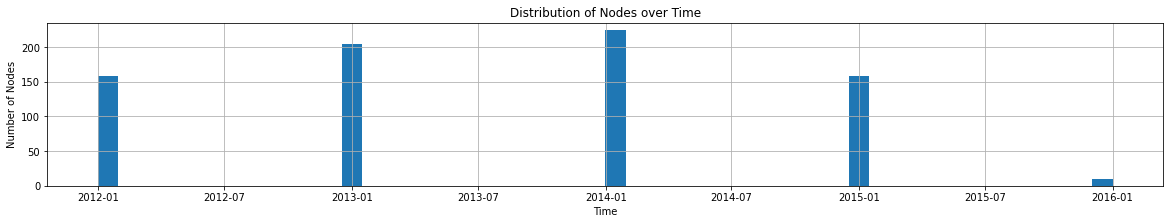

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.756028,aaai,0.025851,aaai,0.0,&Eacute
1,0.000843,Dacheng Tao,0.252134,"Ask, and Shall You Receive? Understanding Desi...",0.000211,Dacheng Tao,0.0,Charmgil Hong
2,0.000749,Yu Zhang,0.252088,Modeling Evolving Relationships Between Charac...,0.000197,Yu Zhang,0.0,Bo Yang 0002
3,0.000655,Alessandro Cimatti,0.252088,Inferring Interpersonal Relations in Narrative...,0.000175,Ivor W. Tsang,0.0,Boi Faltings
4,0.000655,Ivor W. Tsang,0.243503,Discriminatively Enhanced Topic Models.,0.000172,Shaowei Cai,0.0,Bojun Tu
5,0.000655,Shaowei Cai,0.007593,Yu Zhang,0.000171,Alessandro Cimatti,0.0,Boris Motik
6,0.000562,&Eacute,0.005524,Dacheng Tao,0.000159,&Eacute,0.0,Boyu Wang
7,0.000562,Elias Bareinboim,0.003846,Red-Black Relaxed Plan Heuristics.,0.000158,Elias Bareinboim,0.0,Branislav Bosansk&yacute
8,0.000562,Freddy L&eacute,0.003732,Integrating Image Clustering and Codebook Lear...,0.000157,Nina Narodytska,0.0,C. Lee Giles
9,0.000562,Hai Wan,0.003479,&Eacute,0.000156,Nicola Gatti,0.0,Caiming Xiong


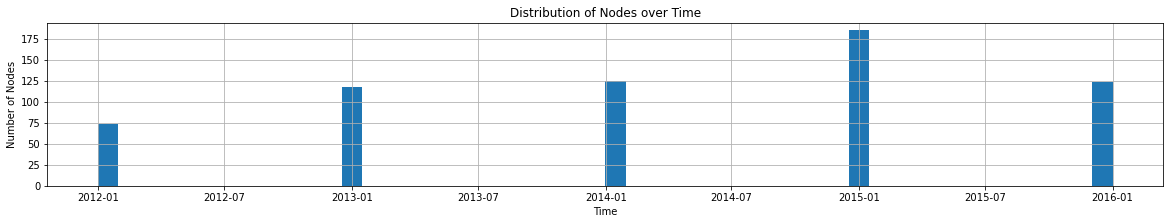

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000562,Miguel &Aacute,0.002282,Miguel &Aacute,0.000153,Miguel &Aacute,0.0,. Carreira-Perpi&ntilde
1,0.000281,. Carreira-Perpi&ntilde,0.002018,LASS: A Simple Assignment Model with Laplacian...,0.000101,Learning Optimally Sparse Support Vector Machi...,0.0,Entropic Affinities: Properties and Efficient ...
2,0.000281,Entropic Affinities: Properties and Efficient ...,0.001632,The Role of Dimensionality Reduction in Classi...,0.000093,Stochastic Optimization of PCA with Capped MSG.,0.0,On Deep Multi-View Representation Learning.
3,0.000281,On Deep Multi-View Representation Learning.,0.001254,Hashing with binary autoencoders.,0.000090,On Deep Multi-View Representation Learning.,0.0,Learning Optimally Sparse Support Vector Machi...
4,0.000281,Learning Optimally Sparse Support Vector Machi...,0.000768,"A fast, universal algorithm to learn parametri...",0.000084,The Role of Dimensionality Reduction in Classi...,0.0,Hashing with binary autoencoders.
5,0.000281,Hashing with binary autoencoders.,0.000736,. Carreira-Perpi&ntilde,0.000084,Locally Linear Landmarks for Large-Scale Manif...,0.0,Locally Linear Landmarks for Large-Scale Manif...
6,0.000281,Locally Linear Landmarks for Large-Scale Manif...,0.000371,Entropic Affinities: Properties and Efficient ...,0.000083,Entropic Affinities: Properties and Efficient ...,0.0,LASS: A Simple Assignment Model with Laplacian...
7,0.000281,LASS: A Simple Assignment Model with Laplacian...,0.000350,Weiran Wang,0.000082,. Carreira-Perpi&ntilde,0.0,The Role of Dimensionality Reduction in Classi...
8,0.000281,The Role of Dimensionality Reduction in Classi...,0.000256,On Deep Multi-View Representation Learning.,0.000082,Hashing with binary autoencoders.,0.0,"A fast, universal algorithm to learn parametri..."
9,0.000281,"A fast, universal algorithm to learn parametri...",0.000251,Locally Linear Landmarks for Large-Scale Manif...,0.000081,"A fast, universal algorithm to learn parametri...",0.0,Stochastic Optimization of PCA with Capped MSG.


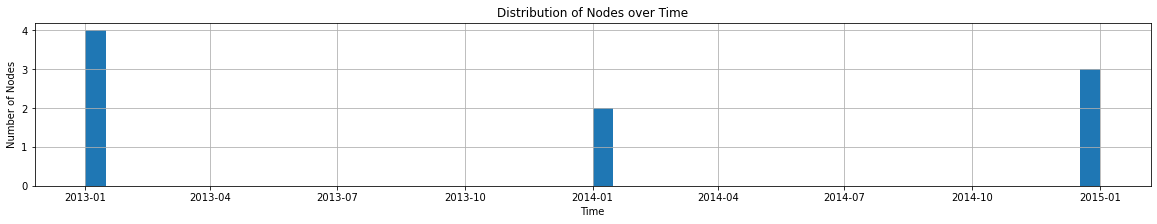

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.064501,nips,0.087508,nips,0.017231,nips,0.0,Distributed Submodular Maximization: Identifyi...
1,0.001030,Cho-Jui Hsieh,0.002768,Scalable Coordinate Descent Approaches to Para...,0.000260,Cho-Jui Hsieh,0.0,Anshumali Shrivastava
2,0.000936,Pradeep Ravikumar,0.002418,Nan Jiang,0.000231,Pradeep Ravikumar,0.0,Alon Orlitsky
3,0.000936,Eunho Yang,0.002397,Large-Scale Optimistic Adaptive Submodularity.,0.000229,Ping Li 0001,0.0,Amin Karbasi
4,0.000843,Daniel Tarlow,0.002350,Branislav Kveton,0.000224,Eunho Yang,0.0,Amir Sani
5,0.000843,Ping Li 0001,0.002307,Online Kernel Selection: Algorithms and Evalua...,0.000215,Daniel Tarlow,0.0,Ananda Theertha Suresh
6,0.000749,Ruslan Salakhutdinov,0.002141,Spectral Learning of Predictive State Represen...,0.000196,Nan Du,0.0,Andrea Montanari
7,0.000749,Arindam Banerjee,0.002141,Improving Predictive State Representations via...,0.000191,Rishabh K. Iyer,0.0,Andreas Krause
8,0.000749,Rishabh K. Iyer,0.002097,Rafael M. Frongillo,0.000190,Ruslan Salakhutdinov,0.0,Andrej Karpathy
9,0.000749,Nan Du,0.002078,Lijun Zhang 0005,0.000190,Arindam Banerjee,0.0,Animashree Anandkumar


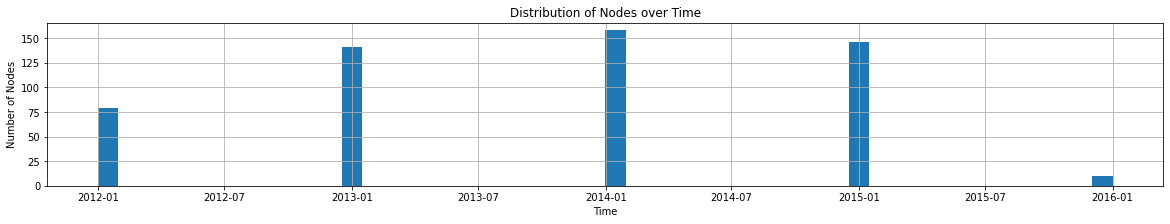

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000749,Arthur Choi,0.002653,Arthur Choi,0.000198,Arthur Choi,0.0,EDML for Learning Parameters in Directed and U...
1,0.000655,Stefano Ermon,0.001719,Pedro M. Domingos,0.000166,Stefano Ermon,0.0,Fast Lifted MAP Inference via Partitioning.
2,0.000562,Pedro M. Domingos,0.001592,Stefano Ermon,0.000152,Pedro M. Domingos,0.0,Bistra N. Dilkina
3,0.000468,Yexiang Xue,0.001540,Ronan Le Bras,0.000122,Yexiang Xue,0.0,Arthur Choi
4,0.000374,Mathias Niepert,0.001447,ClouDiA: a deployment advisor for public clouds.,0.000109,Vibhav Gogate,0.0,Aniruddh Nath
5,0.000374,Carla P. Gomes,0.001379,Pattern Decomposition with Complex Combinatori...,0.000109,Aniruddh Nath,0.0,Adnan Darwiche
6,0.000374,Deepak Venugopal,0.001279,An Integer Polynomial Programming Based Framew...,0.000107,Mathias Niepert,0.0,Abram L. Friesen
7,0.000374,Guy Van den Broeck,0.001123,Somdeb Sarkhel,0.000107,Ronan LeBras,0.0,Bounding the Cost of Search-Based Lifted Infer...
8,0.000374,Aniruddh Nath,0.001065,Decomposing Parameter Estimation Problems.,0.000105,Somdeb Sarkhel,0.0,Learning Ensembles of Cutset Networks.
9,0.000374,Ronan LeBras,0.001065,EDML for Learning Parameters in Directed and U...,0.000104,Deepak Venugopal,0.0,Decomposing Parameter Estimation Problems.


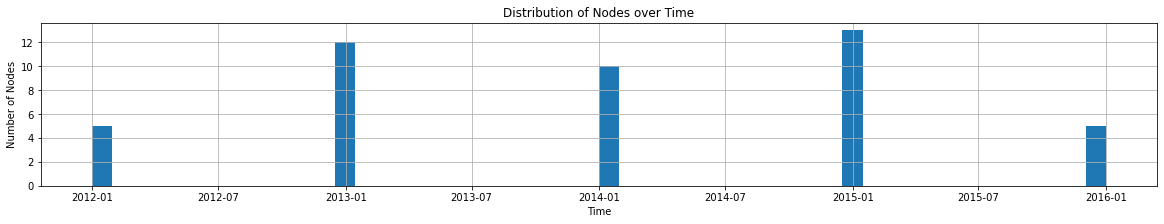

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.720608547471431
Number of communities: 697


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

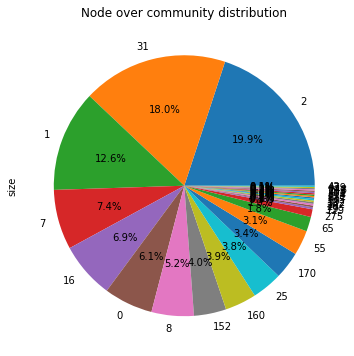

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.043157,ijcai,0.026120,ijcai,0.011525,ijcai,0.0,&Aacute
1,0.001217,Andr&eacute,0.006506,Andr&eacute,0.000328,Andr&eacute,0.0,Stable Model Counting and Its Application in P...
2,0.000749,Diego Calvanese,0.001881,Incremental Stochastic Factorization for Onlin...,0.000209,Diego Calvanese,0.0,Akshat Kumar
3,0.000655,Craig Boutilier,0.001881,Tree-Based On-Line Reinforcement Learning.,0.000172,Craig Boutilier,0.0,Adway Mitra
4,0.000468,Adish Singla,0.001655,Robust Winners and Winner Determination Polici...,0.000138,Adish Singla,0.0,Adish Singla
5,0.000468,Yuri Malitsky,0.001621,On-line Reinforcement Learning Using Increment...,0.000134,Yuri Malitsky,0.0,Abdallah Saffidine
6,0.000468,Francesco Belardinelli,0.001193,Model-Lite Case-Based Planning.,0.000133,Marc Lanctot,0.0,Aaron W. Dennis
7,0.000468,Gerhard Lakemeyer,0.001169,Pareto Ensemble Pruning.,0.000131,Shlomo Zilberstein,0.0,Subset Selection by Pareto Optimization.
8,0.000468,Shlomo Zilberstein,0.000877,Diego Calvanese,0.000129,Francesco Belardinelli,0.0,Learning the Architecture of Sum-Product Netwo...
9,0.000468,Thomas Lukasiewicz,0.000822,Adish Singla,0.000129,Thomas Lukasiewicz,0.0,Preference Elicitation and Interview Minimizat...


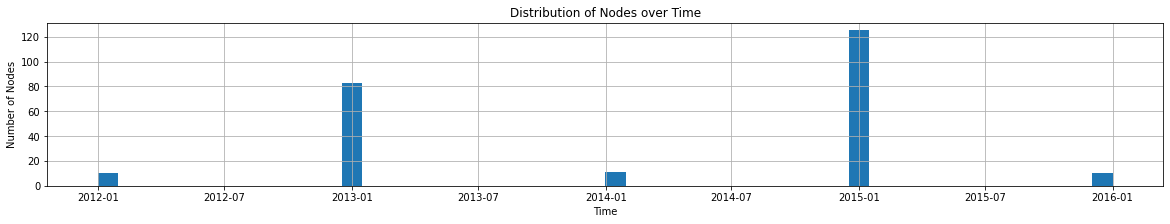

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.064501,nips,0.087508,nips,0.017231,nips,0.0,Distributed Submodular Maximization: Identifyi...
1,0.001217,Huan Xu,0.009385,Xin Wang,0.000304,Huan Xu,0.0,Arthur Gretton
2,0.001030,Xin Wang,0.003674,Small-Variance Asymptotics for Dirichlet Proce...,0.000274,Xin Wang,0.0,Agnieszka Grabska-Barwinska
3,0.000936,Elad Hazan,0.002937,Write-righter: An Academic Writing Assistant S...,0.000247,Elad Hazan,0.0,Akshay Krishnamurthy
4,0.000843,Ping Li 0001,0.002718,Yining Wang,0.000229,Ping Li 0001,0.0,Alekh Agarwal
5,0.000749,Arindam Banerjee,0.002397,Large-Scale Optimistic Adaptive Submodularity.,0.000191,Rishabh K. Iyer,0.0,Alessandro Rudi
6,0.000749,Rishabh K. Iyer,0.002307,Online Kernel Selection: Algorithms and Evalua...,0.000190,Arindam Banerjee,0.0,Alexandra Carpentier
7,0.000655,Yining Wang,0.002212,Jiashi Feng,0.000167,Yining Wang,0.0,Alina Beygelzimer
8,0.000562,Mehrdad Mahdavi,0.002153,Noise-Adaptive Margin-Based Active Learning an...,0.000157,Nicolas Heess,0.0,Alkis Gotovos
9,0.000562,Alekh Agarwal,0.002141,Spectral Thompson Sampling.,0.000153,Xi Chen,0.0,Amin Karbasi


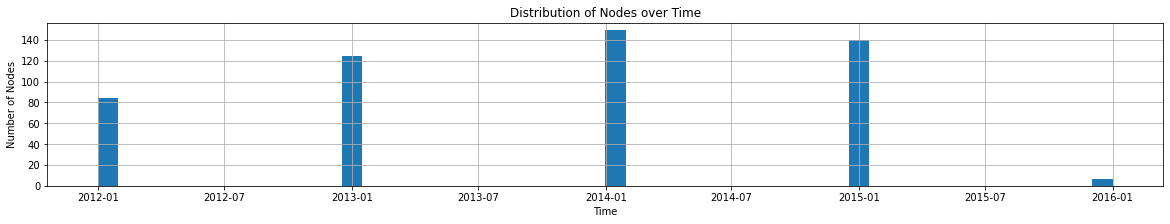

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.756028,aaai,0.025851,aaai,0.0,&Eacute
1,0.001872,Feiping Nie,0.252134,"Ask, and Shall You Receive? Understanding Desi...",0.000453,Feiping Nie,0.0,Anders S&oslash
2,0.001217,Chris H. Q. Ding,0.252088,Modeling Evolving Relationships Between Charac...,0.000309,Deguang Kong,0.0,Arthur Choi
3,0.001217,Deguang Kong,0.252088,Inferring Interpersonal Relations in Narrative...,0.000300,Chris H. Q. Ding,0.0,Aron Laszka
4,0.001123,Yang Yang,0.243503,Discriminatively Enhanced Topic Models.,0.000293,Yang Yang,0.0,Aron Culotta
5,0.001030,Vaishak Belle,0.008853,Feiping Nie,0.000259,Vaishak Belle,0.0,Ariel Felner
6,0.000843,Edith Elkind,0.007593,Yu Zhang,0.000236,Wei Chen,0.0,Ariel D. Procaccia
7,0.000843,Wei Chen,0.006152,Chris H. Q. Ding,0.000218,Edith Elkind,0.0,Aniruddh Nath
8,0.000749,Chao Zhang,0.005984,Wei Chen,0.000214,Hao Wang,0.0,Andrey Kolobov
9,0.000749,Hao Wang,0.005746,Chao Zhang,0.000205,Chao Zhang,0.0,Amy McGovern


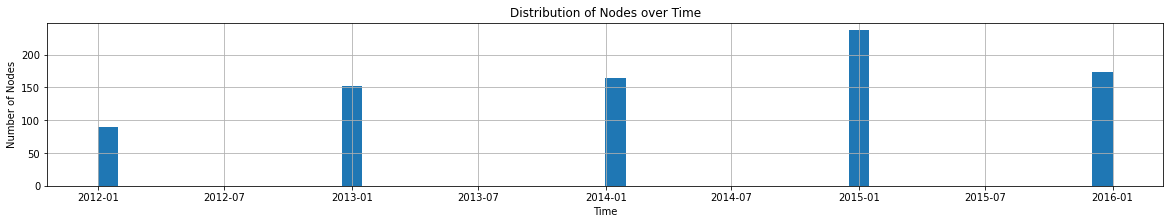

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000281,An Agent-Based Model of the Emergence and Tran...,0.000094,An Agent-Based Model of the Emergence and Tran...,0.000092,An Agent-Based Model of the Emergence and Tran...,0.0,&ntilde
1,0.000281,An Agent-Based Model Studying the Acquisition ...,0.000094,An Agent-Based Model Studying the Acquisition ...,0.000092,An Agent-Based Model Studying the Acquisition ...,0.0,An Agent-Based Model of the Emergence and Tran...
2,0.000187,&ntilde,0.000000,&ntilde,0.000065,&ntilde,0.0,An Agent-Based Model Studying the Acquisition ...
3,0.000187,Josefina Sierra-Santib&aacute,0.000000,Josefina Sierra-Santib&aacute,0.000065,Josefina Sierra-Santib&aacute,0.0,Josefina Sierra-Santib&aacute


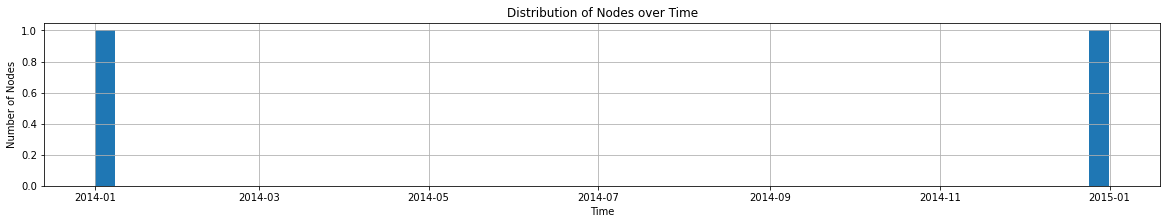

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000562,Miguel &Aacute,0.002282,Miguel &Aacute,0.000153,Miguel &Aacute,0.0,. Carreira-Perpi&ntilde
1,0.000281,. Carreira-Perpi&ntilde,0.002018,LASS: A Simple Assignment Model with Laplacian...,0.000084,Locally Linear Landmarks for Large-Scale Manif...,0.0,Entropic Affinities: Properties and Efficient ...
2,0.000281,Entropic Affinities: Properties and Efficient ...,0.001254,Hashing with binary autoencoders.,0.000083,Entropic Affinities: Properties and Efficient ...,0.0,Hashing with binary autoencoders.
3,0.000281,Hashing with binary autoencoders.,0.000768,"A fast, universal algorithm to learn parametri...",0.000082,. Carreira-Perpi&ntilde,0.0,Locally Linear Landmarks for Large-Scale Manif...
4,0.000281,Locally Linear Landmarks for Large-Scale Manif...,0.000736,. Carreira-Perpi&ntilde,0.000082,Hashing with binary autoencoders.,0.0,LASS: A Simple Assignment Model with Laplacian...
5,0.000281,LASS: A Simple Assignment Model with Laplacian...,0.000371,Entropic Affinities: Properties and Efficient ...,0.000081,"A fast, universal algorithm to learn parametri...",0.0,"A fast, universal algorithm to learn parametri..."
6,0.000281,"A fast, universal algorithm to learn parametri...",0.000251,Locally Linear Landmarks for Large-Scale Manif...,0.000081,LASS: A Simple Assignment Model with Laplacian...,0.0,Max Vladymyrov
7,0.000187,Max Vladymyrov,0.000000,Max Vladymyrov,0.000061,Max Vladymyrov,0.0,Miguel &Aacute


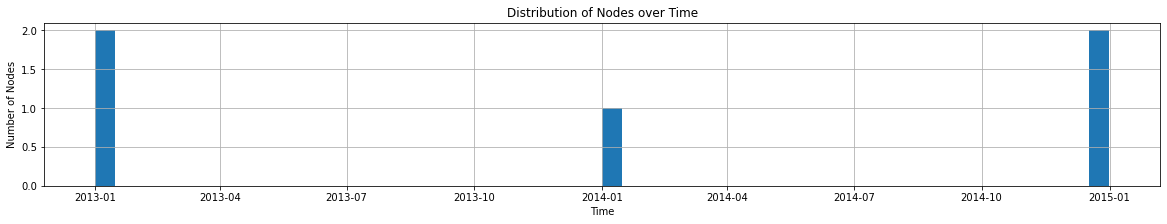

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000281,On crowdsensed data acquisition using multi-di...,0.00014,On crowdsensed data acquisition using multi-di...,0.000106,On crowdsensed data acquisition using multi-di...,0.0,On crowdsensed data acquisition using multi-di...
1,0.000281,AFFINITY: Efficiently querying statistical mea...,0.00014,AFFINITY: Efficiently querying statistical mea...,0.000106,AFFINITY: Efficiently querying statistical mea...,0.0,AFFINITY: Efficiently querying statistical mea...
2,0.000187,Saket Sathe,0.00000,Karl Aberer,0.000075,Saket Sathe,0.0,Saket Sathe
3,0.000094,Karl Aberer,0.00000,Saket Sathe,0.000044,Karl Aberer,NaN,Karl Aberer
4,0.000094,Timos K. Sellis,0.00000,Timos K. Sellis,0.000044,Timos K. Sellis,NaN,Timos K. Sellis


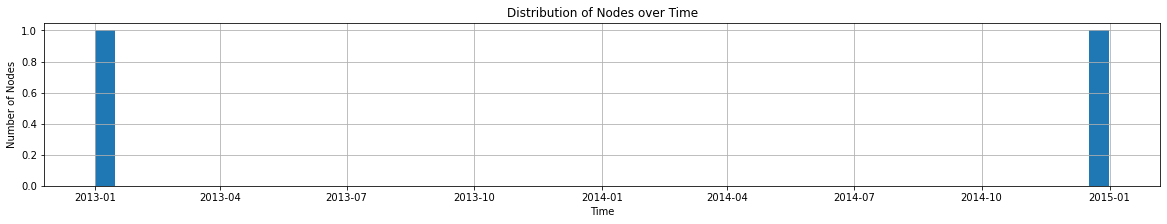

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')